In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/data

/content/drive/My Drive/data


In [0]:
import pandas as pd

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
w_train = pd.read_csv("weather_train.csv")
w_test = pd.read_csv("weather_test.csv")
meta_building = pd.read_csv("building_metadata.csv")

In [0]:
mer_data = pd.merge(train, meta_building, on = 'building_id')
mer2_data = mer_data[(mer_data['site_id']==2)&(mer_data['primary_use']=='Office')]
site2_office = mer2_data.groupby(['timestamp'])['meter_reading'].sum()

In [0]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [7]:
!pip install pyramid.arima

     |████████████████████████████████| 604kB 9.6MB/s 


In [0]:
site2_weather = w_train[w_train['site_id'] == 2]
exo2 = site2_weather[['timestamp','air_temperature','dew_temperature','precip_depth_1_hr','sea_level_pressure','wind_speed']]
exo2 = exo2.fillna(method='bfill')
total = pd.merge(site2_office,exo2, how='outer', on='timestamp').fillna(method='bfill')
total2 = total.copy()

In [20]:
total.head()

,timestamp,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed
0,2016-01-01 00:00:00,2733.1470,15.6,-5.6,0.0,1015.3,3.6
1,2016-01-01 01:00:00,2727.7944,13.9,-5.6,0.0,1015.6,4.1
2,2016-01-01 02:00:00,2777.4856,13.3,-5.6,0.0,1016.0,3.1
3,2016-01-01 03:00:00,2874.1859,12.2,-6.1,0.0,1016.6,3.1
4,2016-01-01 04:00:00,2945.0675,11.7,-6.7,0.0,1017.0,3.1


In [0]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

float_array = total.iloc[:,1].values.astype(float)
scaled_array = min_max_scaler.fit_transform(float_array.reshape(-1,1))
total2.iloc[:,1]=scaled_array

float_array = total.iloc[:,2].values.astype(float)
scaled_array = min_max_scaler.fit_transform(float_array.reshape(-1,1))
total2.iloc[:,2]=scaled_array

float_array = total.iloc[:,3].values.astype(float)
scaled_array = min_max_scaler.fit_transform(float_array.reshape(-1,1))
total2.iloc[:,3]=scaled_array

float_array = total.iloc[:,4].values.astype(float)
scaled_array = min_max_scaler.fit_transform(float_array.reshape(-1,1))
total2.iloc[:,4]=scaled_array

float_array = total.iloc[:,5].values.astype(float)
scaled_array = min_max_scaler.fit_transform(float_array.reshape(-1,1))
total2.iloc[:,5]=scaled_array

float_array = total.iloc[:,6].values.astype(float)
scaled_array = min_max_scaler.fit_transform(float_array.reshape(-1,1))
total2.iloc[:,6]=scaled_array


In [25]:
total2.head()

,timestamp,meter_reading,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_speed
0,2016-01-01 00:00:00,0.221033,0.297778,0.286420,0.007519,0.553633,0.233766
1,2016-01-01 01:00:00,0.220558,0.260000,0.286420,0.007519,0.564014,0.266234
2,2016-01-01 02:00:00,0.224972,0.246667,0.286420,0.007519,0.577855,0.201299
3,2016-01-01 03:00:00,0.233563,0.222222,0.274074,0.007519,0.598616,0.201299
4,2016-01-01 04:00:00,0.239860,0.211111,0.259259,0.007519,0.612457,0.201299


In [0]:
total3 = total2.copy()
date_tmp = total3['timestamp']
tmp = pd.DataFrame(date_tmp).rename(columns = {'timestamp' : 'weekday'})
tmp['weekday'] = pd.to_datetime(tmp['weekday'])
tmp = pd.DataFrame(tmp.set_index('weekday').index.weekday)

In [0]:
import calendar

holiday1 = pd.get_dummies(tmp['weekday'].apply(lambda x: calendar.day_name[x])).iloc[:,2:4]
holiday2 = pd.DataFrame(holiday1.iloc[:,0] +holiday1.iloc[:,1]).rename(columns = {0:'weekend'})
total3['weekend']=holiday2


In [31]:
from pyramid.arima import auto_arima

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/pyramid/__init__.py:68: UserWarning: 
    The 'pyramid' package will be migrating to a new namespace beginning in 
    version 1.0.0: 'pmdarima'. This is due to a pac

In [32]:
model_1 = auto_arima(total3['meter_reading'],exogenous = total3.iloc[:,2:], max_p= 5, max_q=4,max_P = 8, S=24,out_of_sample_size = 720)

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", Conve

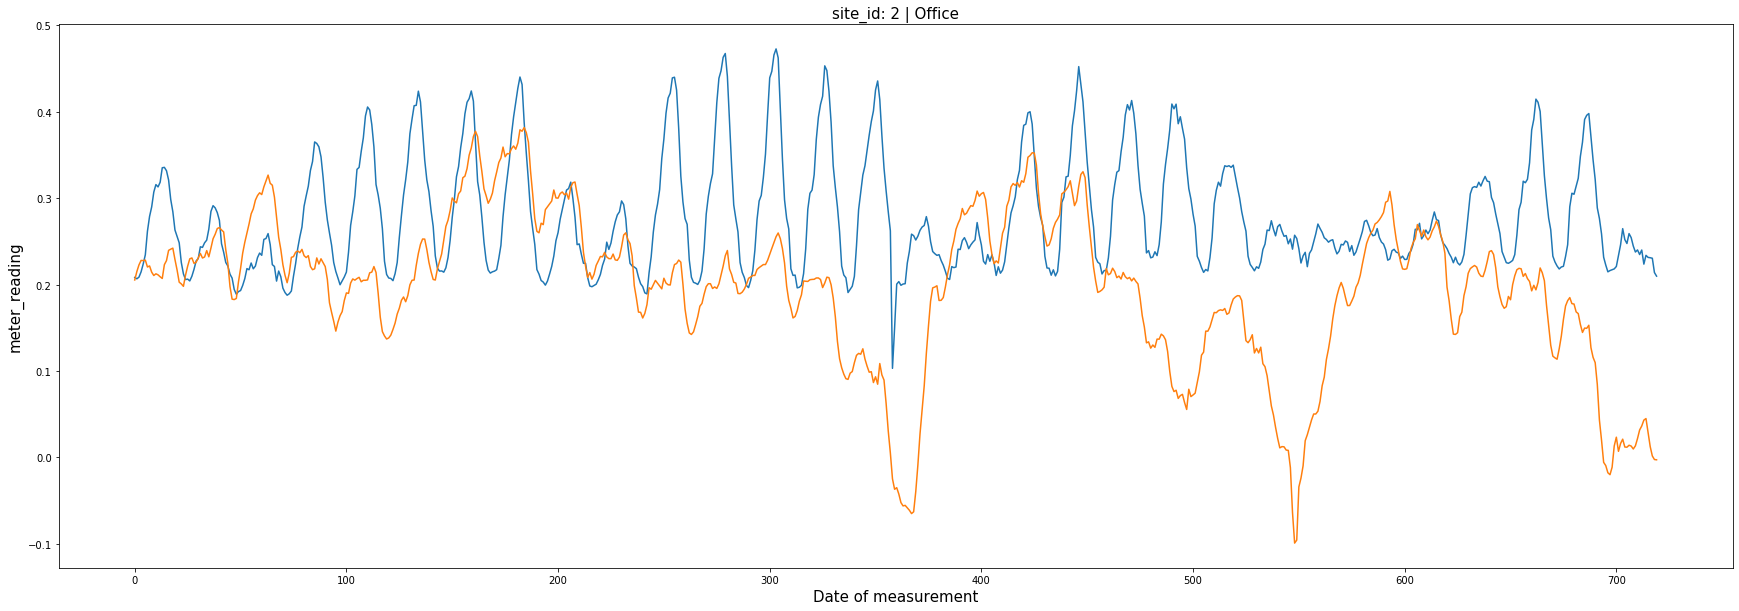

In [35]:
fig = plt.figure(figsize=(30,10))
plt.title('site_id: 2 | Office' ,fontsize=15)
plt.xlabel("Date of measurement",fontsize=15)
plt.ylabel("meter_reading",fontsize=15)
plt.plot(total3['meter_reading'][-720:].reset_index(drop = True))
plt.plot(model_1.predict(n_periods = 720, exogenous=total3.iloc[-720:,2:]))

In [0]:
total4 = total3.copy()
total4.iloc[-720:,1] = 0
total4.to_excel("scaled_data.xlsx")